In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

***
***
# Classifying Qwerties with a simple linear ANN.
- using only linear layers, the previous projects have always had nonlinear hidden layer(s).
- trying to fix model performance inconsistency, where it either epically fails or works surprisingly good.
- Will do another parametric experiment with various fixed learning rates and gauge model performance.


- to solve the performance issues, will try removing the nonlinear activation layers from the model.

In [2]:
# creating dataset
def create_data_cloud(num_per_cluster, blur_value):
    # center of data cloud
    A = [1,3]
    B = [1,-2]

    # generating data points
    a = [A[0]+np.random.randn(num_per_cluster)*blur_value, A[1]+np.random.randn(num_per_cluster)*blur_value]
    b = [B[0]+np.random.randn(num_per_cluster)*blur_value, B[1]+np.random.randn(num_per_cluster)*blur_value]

    # category labels (dummy or 'hot' encoding)
    labels_np = np.vstack((np.zeros((num_per_cluster,1)), np.ones((num_per_cluster, 1)))) # all of dataset a is labeled as 0, all of b as 1

    # concatenate data into matrix
    data_np = np.hstack((a,b)).T

    # convert numpy matrix to pytorch tensor
    data = torch.tensor(data_np).float()
    labels = torch.tensor(labels_np).float()

    return data, labels

In [3]:
# building multi-layer model
def ANN_classify_build(m_learning_rate):
    ANN_classify = nn.Sequential(
        nn.Linear(2,16), # input layer
        #nn.ReLU(),       # activation unit
        nn.Linear(16,1), # hidden layer
        #nn.ReLU(),       # activation unit
        nn.Linear(1,1),  # output unit
        nn.Sigmoid()     # final activation
    )

    # model functions
    loss_func = nn.BCELoss() # not recommended, use nn.BCEWithLogitsLoss() instead.
    optimizer = torch.optim.SGD(ANN_classify.parameters(), lr=m_learning_rate)
    
    return ANN_classify, loss_func, optimizer

In [4]:
# training model
def ANN_classify_training(model, loss_function, m_optimizer, input_data, input_labels, epochs = 1000):
    
    # parameters
    losses = torch.zeros(epochs)

    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = model(input_data)

        # calculating loss
        loss = loss_function(y_hat, input_labels)
        losses[epoch_IDX] = loss

        # backprop
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

    # final forward pass
    final_predictions = model(input_data) # final predictions from fully trained model

    # calculating accuracy based on if predicted label == actual label
    # using 0.5 because data is not raw output. 0.5 is the decision boundary because the output has been put through a sigmoid function.
    decision_boundary = 0.5
    total_accuracy = 100*torch.mean(((final_predictions > decision_boundary) == input_labels).float()) # used in almost every model for categorization.

    return final_predictions,losses, total_accuracy

***
### Quick test of model and functions.
- This is a good idea, especially before doing a larger experiment.

Test model accuracy: 99.5%


<function matplotlib.pyplot.show(close=None, block=None)>

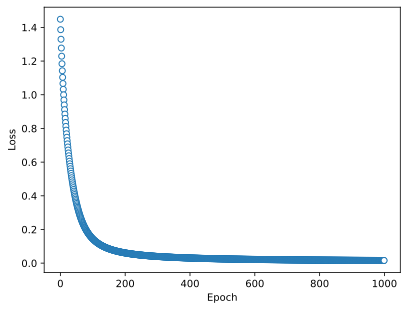

In [5]:
# quick sanity check

# generating data
n_test = 100
blur_test = 1
sanity_data, sanity_labels = create_data_cloud(n_test, blur_test)

# building model
test_model, test_loss_func, test_optimizer = ANN_classify_build(0.01)

# training model
test_predic, test_losses, test_acc = ANN_classify_training(test_model, test_loss_func, test_optimizer, sanity_data, sanity_labels)

print("Test model accuracy: %g%%"%test_acc)

# plotting losses
plt.plot(test_losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show

***
## Parametric experiment

In [6]:
# generating data
n_per_cluster = 100
blur = 1
generated_data, generated_labels = create_data_cloud(n_per_cluster, blur)

In [7]:
# setting up parametric experiment
p_learning_rates = np.linspace(0.001, 0.1, 50) # varied
p_epochs = 1000 # constant

# storing results
accuracy_each_lr = []
losses_by_run = np.zeros((len(p_learning_rates), p_epochs))

# parametric study
for i, lr_value in enumerate(p_learning_rates):

    # creating and training model
    ANN_model, ANN_loss, ANN_optimizer = ANN_classify_build(lr_value)
    results, model_losses, model_accuracy = ANN_classify_training(ANN_model, ANN_loss, ANN_optimizer, generated_data, generated_labels) # results will be between [0,1]

    # storing results for each run
    accuracy_each_lr.append(model_accuracy)
    losses_by_run[i,:] = model_losses.detach()

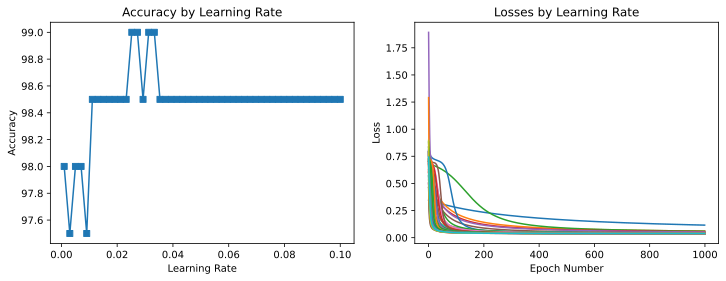

In [8]:
# plotting results
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot for accuracy
ax[0].plot(p_learning_rates,accuracy_each_lr, 's-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by Learning Rate')

# plot for losses
ax[1].plot(losses_by_run.T)
ax[1].set_xlabel('Epoch Number')
ax[1].set_ylabel('Loss')
ax[1].set_title('Losses by Learning Rate')

plt.show()

### Interpreting the results
- Almost all of the losses converge towards 0. They all hit an asymptote at the bottom, meaning that the model didn't have much more to learn.
- The accuracy is far more stable.  All of the learning rates resulted in the model predicted with above 90% accuracy.

- It is amazing how much better the model performed. It was reliable, accurate, and learned quickly. 1000 epochs didn't even seem necessary.

***

#### Final takeaways
- simple problems are best solved with simple solutions
- The qwerty dataset is linearly solvable, because a straight line can be drawn to separate (categorize) the data points.
- The nonlinear layers forced the model to find a more complex solution. This is where the lack of stability came from.